# DQN using CNN <br>
This version uses @will's Memeory buffer and the same function he uses to calculate loss.

In [1]:
import torch

import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
from collections import namedtuple
import numpy as np

from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt
import pandas as pd


# Define the Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(105, 128).to(device)
        #print("fc1", self.fc1.device)
        self.fc2 = nn.Linear(128, 128).to(device)
        self.fc3 = nn.Linear(128, 5).to(device)

    def forward(self, x):
        x.to(torch.device('cpu'))
        #print(x.device)
        x = torch.relu(self.fc1(x)).to(device) 
        x = torch.relu(self.fc2(x)).to(device) 
        x = self.fc3(x).to(device)
        return x



@ will's Replay Buffer class

In [2]:
from typing import Dict, Tuple


class ReplayBuffer:
    """
    Class representing a simple replay buffer that accepts stacked images.
    """
    
    def __init__(self, obs_shape: Tuple, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_shape], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_shape], dtype=np.float32)

        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)

        self.max_size = size
        self.batch_size = batch_size

        self.ptr = 0
        self.size = 0

    def store(self, obs: np.ndarray, act: np.ndarray, rew: np.ndarray, next_obs: np.ndarray, done: bool):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        # Draw `batch_size` no. samples (without replacement) as indexes.
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )
    
    def __len__(self) -> int:
        return self.size

environment setup second config yielded better results

In [15]:
import gymnasium as gym
# config = {
#        "observation": {
#            "type": "GrayscaleObservation",
#            "observation_shape": (128, 64),
#            "stack_size": 4,
#            "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
#            "scaling": 1.75,
#        },
#        "policy_frequency": 2
#    }


config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "order": "sorted"
    }
}
env = gym.make("highway-fast-v0", render_mode = "rgb_array")
env.configure(config)


c:\Users\giova\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


Set device to cuda. Check here when debugging

In [4]:
device = torch.device('cuda')

Select action class only used in training

In [5]:
def select_action(epsilon, state, Q_net):
    # Epsilon-greedy action selection
    if random.random() < epsilon:
        action = env.action_space.sample()  # Choose random action
    else:
        with torch.no_grad():
            #print(episode)
            #q_values = Q_net(torch.tensor(state, dtype=torch.float32, device= device)).to(device)
            q_values = Q_net(torch.FloatTensor(state).to(device)).argmax()
            #clipped_q_values = q_values[0][:5]  # Consider valid actions only
            action = q_values.detach().cpu().item() #torch.argmax(clipped_q_values).clamp(0, 4).item()
            
            #action = torch.argmax(valid_actions).item() #//5
    
    return action
            

Initialization and DQN algorithm

In [16]:
# Initialize networks
input_size = 5  # Assuming state size is 4 for example
output_size = 5 # Assuming 2 actions
Q_net = QNetwork(input_size, output_size).to(device) 
target_net = QNetwork(input_size, output_size).to(device) 
target_net.load_state_dict(Q_net.state_dict()) # Copy weights from Q_net to target_net
#target_net.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(Q_net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

# Initialize other parameters
epsilon = 0.9  # Initial exploration rate
epsilon_min = 0.01
epsilon_decay = 0.0001
gamma = 0.8  # Discount factor
batch_size = 64
# memory = ReplayMemory(15000)
target_update = 50  # Update target network every `target_update` steps
M = 1200
T= 50
total_a =[]
memory = ReplayBuffer(105, 15000, batch_size)
loss = 1
transition = list()

total_loss = []
total_scores = []
episode_score = 0


# Training loop
for episode in range(1, M+1):  # Replace M with the number of episodes
    state = env.reset()[0].flatten()  # Initialize environment and get initial state
    #state = torch.tensor(env.reset()[0], dtype=torch.float32).to(device)
    print(episode)
    episode_score = 0
    
    #env.render()
    total_a =[]
    for t in range(1, T+1):  # Replace T with maximum time steps per episode
        action = select_action(epsilon, state, Q_net)
        total_a.append(action)
        #print(action)
        # Take action and observe next_state, reward
        obs, reward, terminated, truncated, _ = env.step(action)
        obs = obs.flatten()
        episode_score += reward

        done = truncated or terminated
        
        #env.render()
        # Store transition in replay memory
        transition = [state, action, reward, obs, done]
        memory.store(*transition)
        #memory.push(state, action, obs, reward)
        if done:
            # env.render()
            #env.close()
            break
        # Sample a random minibatch of transitions
        if len(memory) > batch_size:
            # transitions = memory.sample(batch_size)
            # batch = Transition(*zip(*transitions))

            samples = memory.sample_batch()

            state = torch.FloatTensor(samples["obs"]).to(device)
            next_state = torch.FloatTensor(samples["next_obs"]).to(device)
            action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
            reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
            done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

            # Compute Q-value targets
            # non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool).to(device)
            # non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float32).to(device)
            
            # state_batch = torch.tensor(batch.state, dtype=torch.float32).to(device)
            # action_batch = torch.tensor(batch.action, dtype=torch.long).to(device)
            # reward_batch = torch.tensor(batch.reward, dtype=torch.float32).to(device)

            # Q_values = Q_net(state_batch).gather(1, action_batch.unsqueeze(1)).to(device)

            # next_state_values = torch.zeros((batch_size, 64), dtype=torch.float32) #.to(device)
            # next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach() #.to(device)
            # next_state_values = torch.sum(next_state_values, 1).to(device)

            # expected_Q_values = (reward_batch + (gamma * next_state_values)).to(device)

            # Compute loss and backpropagate
            # loss = F.smooth_l1_loss(Q_values, expected_Q_values.unsqueeze(1)).to(device)
            curr_q_value = Q_net(state).gather(1, action)
            next_q_value = target_net(next_state).max(dim=1, keepdim=True)[0].detach()
            mask = 1 - done
            target = (reward + gamma * next_q_value * mask).to(device)

            # Calculate DQN loss
            loss = F.smooth_l1_loss(curr_q_value, target)

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(Q_net.parameters(), 10.0)
            optimizer.step()
        
        
        
        state = obs  # Update state
    total_scores.append(episode_score)
    total_loss.append(loss)  
    print(episode_score)  

    # Update exploration rate
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Update target network every `target_update` steps
    if episode % target_update == 0:
        target_net.load_state_dict(Q_net.state_dict())
        target_net.to(device)
    print(total_a)
        


1
5.330398405928675
[1, 1, 2, 1, 3, 4, 1]
2
2.9131583425367054
[3, 3, 3, 3]
3
1.8467961636381087
[3, 3, 3]
4
6.04644560308565
[3, 3, 3, 3, 3, 3, 3]
5
13.813112164297001
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
6
10.753112164296823
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
7
1.953097444983092
[3, 3, 3]
8
1.8467961636381087
[3, 3, 3]
9
13.046445497630405
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
10
4.753112130683116
[3, 3, 3, 3, 3, 3]
11
12.046445497630883
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
12
1.180129496971442
[3, 3]
13
5.046446298431657
[3, 3, 3, 3, 3, 3]
14
11.179778830964215
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
15
17.545506753600332
[3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 2, 2, 2, 2]
16
3.532710609457764
[2, 2, 2, 2, 2]
17
6.718489676720778
[2, 2, 2, 3, 2, 2, 3, 3]
18
5.113112269752317
[3, 3, 3, 3, 3, 3]
19
14.752640050916133
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2]
20
6.5131583425367054
[2, 2, 2, 2, 3, 3, 2, 3]
21
10.646445497634508
[3, 3, 3, 3, 3,

Loss evaluation

In [7]:
lis= []
for i in total_scores:
    #if i == 1: continue
    lis.append(i.item())
df = pd.DataFrame(lis)

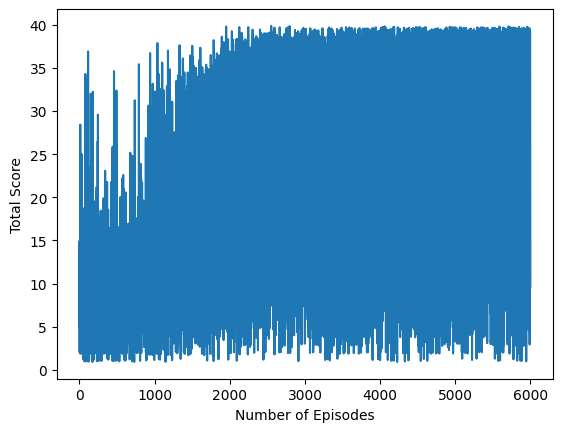

In [59]:
fig, ax = plt.subplots()
ax.plot(df)
ax.set(xlabel = 'Number of Episodes', ylabel = "Total Score")
#plt.legend(loc='upper left')
plt.show()


<Axes: >

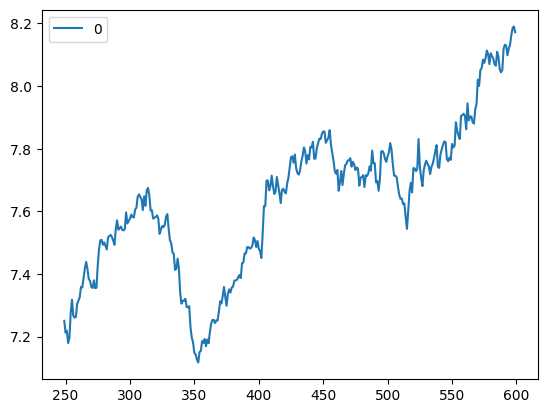

In [9]:
df.rolling(250).mean().plot()

In [28]:
df.to_csv("dqn_scores.csv")

## Test

In [83]:
config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "order": "sorted"
    }
}
env = gym.make("highway-v0", render_mode = "rgb_array")
env.configure(config)

In [13]:
from gymnasium.wrappers import RecordVideo
import numpy as np

env = RecordVideo(env, video_folder="run",
              episode_trigger=lambda e: True)

env.unwrapped.set_record_video_wrapper(env)


##############################################
episode_reward = 0
cuml_reward = []
count = 0
cuml_count = []
episode_speed = []
total_speed = []

###############################################

# Implement the policy using Q-values from the tensor
def get_optimal_action(state):
    q_values = Q_net(torch.FloatTensor(state).to(device)).argmax()

    optimal_action = q_values.detach().cpu().item()
    return optimal_action


for i in range (10):
    # Reset the environment to get the initial state
    print("Episode: ",i)
    state, info = env.reset() #[0].flatten()
    state = state.flatten()

    # Render the environment
    env.render()
    # episode_reward = 0
    # count = 0
    # episode_speed = []
    # Run the policy in the environment
    terminated, truncated = False, False
    while not (terminated or truncated):
        # Get the optimal action for the current state
        action = get_optimal_action(state)
        #count += 1
        # Take the action in the environment

        obs, reward, terminated, truncated, _  = env.step(action)
        #episode_reward += reward
        # Update the current state
        state = obs.flatten()
        #episode_speed.append(_['speed'])
    
        
        # Render the environment
        env.render()

    #print("Reward: ", reward)
    # Close the environment rendering
    env.close()
    # cuml_reward.append(episode_reward)
    # cuml_count.append(count)
    # total_speed.append(episode_speed)


c:\Users\giova\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode:  0
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-0.mp4
Episode:  1
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-1.mp4
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-1.mp4
Episode:  2
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-2.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-2.mp4


Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-2.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-2.mp4
Episode:  3
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-3.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-3.mp4
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-3.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-3.mp4
Episode:  4
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-4.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-4.mp4
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-4.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-4.mp4
Episode:  5
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-5.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-5.mp4
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-5.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-5.mp4
Episode:  6
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-6.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-6.mp4
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-6.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-6.mp4
Episode:  7
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-7.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-7.mp4
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-7.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-7.mp4
Episode:  8
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-8.mp4
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-8.mp4
Episode:  9
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-9.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-9.mp4
Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-9.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run\rl-video-episode-9.mp4


In [11]:
import gymnasium as gym
from gymnasium.wrappers import  RecordEpisodeStatistics, RecordVideo

# Wrap the env by a RecordVideo wrapper
#env = gym.make("highway-v0", render_mode = "rgb_array")
env = RecordVideo(env, video_folder="run-600",
              episode_trigger=lambda e: True)  # record all episodes

# Provide the video recorder to the wrapped environment
# so it can send it intermediate simulation frames.
env.unwrapped.set_record_video_wrapper(env)

# Record a video as usual
obs, info = env.reset()
done = truncated = False
while not (done or truncated):
    action = get_optimal_action(obs.flatten())
    obs, reward, done, truncated, info = env.step(action)
    env.render()
env.close()

NameError: name 'get_optimal_action' is not defined

In [12]:
# Kill switch if you interrupt above cell
env.close()

Moviepy - Building video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\giova\OneDrive\Documenti\GitHub\Group-Assignment\run-600\rl-video-episode-0.mp4


## Agent Speed Evaluation

In [69]:
df1 = pd.DataFrame(total_speed)

In [83]:
df1 = df1.T
df1 = df1.fillna(0)

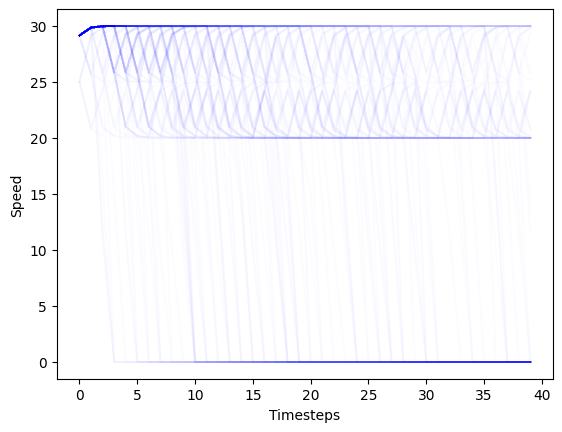

In [146]:
fig, ax = plt.subplots()
ax.plot(df1.T[:50], color ='blue', alpha = 0.01)
ax.set(xlabel = 'Timesteps', ylabel = "Speed")
#plt.legend(loc='upper left')
plt.show()


In [129]:
df1.T[:10]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,29.145559,29.145559,29.145559,29.145559,29.145559,29.145559,29.145559,29.145559,29.145559,29.145559,...,29.145559,29.145559,29.145559,29.145559,29.145559,29.145559,29.145559,29.145559,29.145559,29.145559
1,29.853986,29.853986,29.853986,29.853986,29.853986,29.853986,29.853986,29.853986,29.853986,29.853986,...,29.853986,29.853986,29.853986,29.853986,29.853986,29.853986,29.853986,29.853986,29.853986,29.853986
2,29.975048,29.975048,29.975048,29.975048,29.975048,29.975048,29.975048,29.975048,29.975048,29.975048,...,29.975048,29.975048,29.975048,29.975048,29.975048,29.975048,29.975048,29.975048,29.975048,29.975048
3,29.995736,29.995736,25.850177,29.995736,29.995736,15.041409,29.995736,29.995736,29.995736,29.995736,...,29.995736,25.850177,29.995736,25.850177,29.995736,29.995736,29.995736,29.995736,29.995736,29.995736
4,29.999271,25.853713,29.290844,29.999271,29.999271,0.000000,29.999271,29.999271,29.999271,25.853713,...,29.999271,29.290844,11.417769,25.145285,29.999271,29.999271,25.853713,29.999271,29.999271,29.999271
5,29.999875,21.000331,29.878814,29.999875,29.999875,0.000000,29.999875,29.999875,29.999875,29.291448,...,29.999875,29.878814,0.000000,25.024828,29.999875,29.999875,21.000331,29.999875,29.999875,29.999875
6,29.999979,20.170945,29.979291,29.999979,29.999979,0.000000,29.999979,25.854420,29.999979,29.878917,...,25.854420,25.833732,0.000000,25.004243,29.999979,29.999979,20.170945,29.999979,29.999979,29.999979
7,29.999996,20.029212,29.996461,29.999996,29.999996,0.000000,25.854438,25.146010,29.999996,29.979308,...,27.256148,29.288034,0.000000,20.855166,29.999996,29.999996,24.174771,29.999996,29.999996,29.999996
8,29.999999,20.004992,29.999395,29.999999,25.854441,0.000000,29.291572,29.170510,29.999999,29.996464,...,0.000000,29.878333,0.000000,20.146138,29.999999,29.999999,24.858978,25.854441,29.999999,29.999999
9,30.000000,20.000853,17.274744,30.000000,29.291573,0.000000,29.878938,29.858250,30.000000,17.274004,...,0.000000,25.833650,0.000000,20.024973,30.000000,30.000000,29.121460,14.561290,30.000000,30.000000


In [54]:
torch.save(Q_net.state_dict(), 'q_network.pth')